# Future projections of global hail hazard

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [71]:
import sys
sys.path.append('../xarray_parcel/')
sys.path.append('../aus400_hail/')
                
import dask
import xarray
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from clef.code import *
import cartopy.crs as ccrs
from importlib import reload
import modules.fut_hail as fh
import matplotlib.pyplot as plt
from dask.distributed import Client, Scheduler, LocalCluster

## Setup

In [3]:
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:35571' processes=7 threads=28, memory=126.00 GiB>


## Settings

In [4]:
plt.show()                                        # Start the plotting engine.
plt.rcParams['font.size'] = 13                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

## Model selection

Find models matching criteria. The following criteria are used to select models:

* Must contain variables:
     - `tas`, temperature at surface
     - `ta`, temperature by level
     - `uas`, u wind at surface
     - `ua`, u wind by level
     - `vas`, v wind at surface
     - `va`, v wind by level
     - `huss`, specific humidity at surface
     - `hus`, specific humidity by level
     - `ps`, surface pressure
* Optional variables:
     - `orog`, surface elevation. If missing, orography from CNRM-CM6-1/historical/r1i1p1f2 is interpolated to the same grid and used.
* Must be available with a table ID of `3hr` or `6hrLev` (six hour minimum temporal resolution).
* Must include both historical and SSP5-8.5 experiments.

In [6]:
models = fh.select_models()

## Model warming points

In [11]:
reload(fh)
runs = fh.define_runs(models=models, file='results/runs_list.csv')
runs

BCC-CSM2-MR historical requires 1980-1999, but data for va covers only 2012-2014. Excluding BCC-CSM2-MR.


2023-09-28 10:20:19,937 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-28 10:20:21,342 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-28 10:20:22,583 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-28 10:20:24,258 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-28 10:20:26,018 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-28 10:20:27,886 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-28 10:20:29,101 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-09-28 10:20:30,586 - distributed.utils_perf - WARNING - full garbage collections took

,model,ensemble,exp,institution_id,desc,start_year,end_year
0,CMCC-CM2-SR5,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1,1980,1999
1,CMCC-ESM2,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1,1980,1999
2,CNRM-CM6-1,r1i1p1f2,historical,CNRM-CERFACS,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical....,1980,1999
3,EC-Earth3,r1i1p1f1,historical,EC-Earth-Consortium,CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.histo...,1980,1999
4,GISS-E2-1-G,r1i1p1f2,historical,NASA-GISS,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1980,1999
5,MIROC6,r1i1p1f1,historical,MIROC,CMIP6.CMIP.MIROC.MIROC6.historical.r1i1p1f1,1980,1999
6,MPI-ESM1-2-HR,r1i1p1f1,historical,MPI-M,CMIP6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1...,1980,1999
7,MRI-ESM2-0,r1i1p1f1,historical,MRI,CMIP6.CMIP.MRI.MRI-ESM2-0.historical.r1i1p1f1,1980,1999
8,CMCC-CM2-SR5,r1i1p1f1,ssp585 (2C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,2024,2043
9,CMCC-ESM2,r1i1p1f1,ssp585 (2C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,2030,2049


,model,ensemble,exp,institution_id,desc,start_year,end_year
8,CMCC-CM2-SR5,r1i1p1f1,ssp585 (2C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,2024,2043
9,CMCC-ESM2,r1i1p1f1,ssp585 (2C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,2030,2049
10,CNRM-CM6-1,r1i1p1f2,ssp585 (2C),CNRM-CERFACS,CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp5...,2031,2050
11,EC-Earth3,r1i1p1f1,ssp585 (2C),EC-Earth-Consortium,CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth...,2026,2045
12,GISS-E2-1-G,r1i1p1f2,ssp585 (2C),NASA-GISS,CMIP6.ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585...,2020,2039
13,MIROC6,r1i1p1f1,ssp585 (2C),MIROC,CMIP6.ScenarioMIP.MIROC.MIROC6.ssp585.r1i1p1f1,2044,2063
14,MPI-ESM1-2-HR,r1i1p1f1,ssp585 (2C),DKRZ,CMIP6.ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.r1...,2040,2059
15,MRI-ESM2-0,r1i1p1f1,ssp585 (2C),MRI,CMIP6.ScenarioMIP.MRI.MRI-ESM2-0.ssp585.r1i1p1f1,2029,2048
16,CMCC-CM2-SR5,r1i1p1f1,ssp585 (3C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,2043,2062
17,CMCC-ESM2,r1i1p1f1,ssp585 (3C),CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,2046,2065


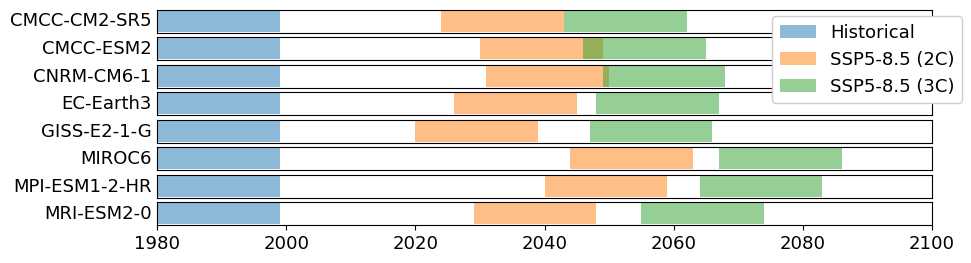

In [196]:
fh.plot_run_years(runs, file='results/run_years.pdf')

Uncomment the following block to (re)create all scripts for generating convective indices for each run. 

In [ ]:
# fh.make_run_scripts(runs=runs)

In [8]:
b = fh.read_all_CMIP_data(model="CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i1p1f1")

/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/6hrLev/va/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/6hrLev/ua/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/6hrLev/ta/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/6hrLev/hus/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/6hrLev/ps/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/3hr/vas/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/3hr/uas/gn/v20200622
/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/3hr/huss/gn/v20200622


2023-09-27 17:27:43,802 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-27 17:27:46,101 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/3hr/tas/gn/v20200622


2023-09-27 17:27:48,724 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-27 17:27:50,567 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-09-27 17:27:52,814 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


In [ ]:
sorted(runs.desc)

Note that grid information is missing from some files for MRI, CMCC, and MPI. The missing information is (as of 19.05.2023):

```
MRI: grid-spec gn, orog version gn/v20190603
CMCC: grid-spec gn, orog version gn/v20210126
MPI: grid-spec gn, orog version gn/v20190710
```

## Process CMIP6 data

Scripts are generated for each model/experiment, under
    
```
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-1.sh
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-2.sh
```

The first processes the first 10 years, the second the last 10 years.

Post-processing into annual/seasonal statistics is done by:

```
post_process_CMIP.sh
```

## Read processed data

In [ ]:
data_dir = '/g/data/up6/tr2908/future_hail_global/CMIP_conv_annual_stats/'
data_exp = '*common_grid.nc'
rename_models = {'EC-Earth_Consortium.EC-Earth3': 'EC-Earth3'}

# Regrid native grids to common grids.
fh.regrid_global(path=f'{data_dir}/*native_grid.nc')

# Open all data.
dat = xarray.open_mfdataset(f'{data_dir}/{data_exp}')

# Shorten model names if required.
dat = dat.assign_coords({'model': [rename_models[x] if x in rename_models else x for x in dat.model.values]})

# Open landsea mask.
lsm = fh.make_landsea_mask()

# Mask to land area only.
dat_land = dat.where(lsm.land == 1)

# Load for speed.
dat = dat.persist()
dat_land = dat_land.persist()

# Transpose - for the ttest the axis over which the t-test should be applied ('year_num') must be first after model/epoch selection.
dat = dat.transpose('model', 'epoch', 'year_num', 'season', 'lat', 'lon')

**CHECK that each model contains the correct epoch and number of timesteps in the annual/seasonal stats**

## Global hail climatology for historical period

In [ ]:
_ = fh.plot_map([dat.annual_hail_proxy.mean('year_num').sel(model=m, epoch='historical') for m in dat.model],
                title=[f'{m}' for m in dat.model.values], figsize=(12,6), disp_proj=ccrs.Robinson(),
                ncols=2, nrows=2, share_scale=True, share_axes=True, grid=False, contour=True,
                scale_label='Mean annual hail-prone days')

## Australian hail climatology for historical period

In [ ]:
d = [dat_land.annual_hail_proxy.mean('year_num').sel(model=m, epoch='historical', lat=slice(-45,-10), lon=slice(110,157)) for m in dat.model]
_ = fh.plot_map(d, title=[f'{m}' for m in dat.model.values], figsize=(12,4), nan_colour='white', contour=True,
                ncols=4, nrows=1, share_scale=True, share_axes=True, grid=False, country='Australia', axis_off=True,
                scale_label='Mean annual hail-prone days')

In [ ]:
fh.plot_seasonal_maps(dat=dat_land.sel(epoch='historical'), variable='seasonal_hail_proxy', 
                      lat_range=slice(-45,-10), lon_range=slice(110,157), country='Australia', contour=True, 
                      axis_off=True, grid=False, figsize=(12,8), scale_label='Hail-prone days per season')

In [ ]:
model = 'CMCC-ESM2'
hist_epoch = 'historical'
fut_epoch = '2C'
import scipy as sp
variable = 'seasonal_hail_proxy'
statres, pval = sp.stats.ttest_rel(a=dat.sel(epoch=fut_epoch, model=model, season='DJF')[variable].values, 
                                   b=dat.sel(epoch=hist_epoch, model=model, season='DJF')[variable].values)

In [ ]:
res_dims = list(dat.sel(epoch=fut_epoch, model=model)[variable].dims)[1:]
{x: dat[x].values for x in res_dims}

In [ ]:
reload(fh)

In [ ]:
d = fh.ttest(dat=dat, fut_epoch='2C', variable='seasonal_hail_proxy')

In [ ]:
dat

In [ ]:
fut_epoch='2C'

res = []
for variable in ['annual_hail_proxy']:
    print(variable)
    tt = fh.ttest(dat=dat, fut_epoch=fut_epoch, variable=variable)
    diffs = dat[variable].sel(epoch=fut_epoch) - dat[variable].sel(epoch='historical')

    r = xarray.Dataset({f'{variable}_mean_diff': diffs.mean('year_num'),
                        f'{variable}_sig_diff': tt.sig})
    r[f'{variable}_mean_diff'].attrs = dat[variable].attrs
    res.append(r)
    
res = xarray.merge(res)

In [ ]:
diffs = res
variable = 'annual_hail_proxy_mean_diff'
diffs[variable]

In [ ]:
diffs = res
variable = 'annual_hail_proxy_mean_diff'

In [ ]:
reload(fh)

sign_aggreement = (np.sign(diffs[variable]).sum('model'))
significant_change = tt.sig.sum('model')
s = np.logical_and(significant_change == dat.model.size,
                   np.abs(sign_aggreement) == dat.model.size)
                  
m = diffs[variable].mean('model')
m.attrs['long_name'] = 'Mean change in annual hail-prone days'
    
_ = fh.plot_map(dat=m, grid=False, divergent=True,
                scale_label='Mean change in annual hail-prone days',
                stippling=s, cmap='RdBu_r', figsize=(12,6), disp_proj=ccrs.Robinson())

Using [Metagrid](https://aims2.llnl.gov/search) to search for CMIP6 data with:

Variables: ua, uas, va, vas, ta, tas, hus, huss, ps
Table ID: 6hrLev, 3hr
Experiments: ssp585, historical
Variant: r1i1p1f1
Resolutions: 50, 100, 250 km

And then selecting models one by one and looking for those with >18 results (9 variables, two experiments):

Not available on NCI - requested

* BCC-CSM2-MR
    - `CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.r1i1p1f1`

* CMCC-CM2-SR5
    - `CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i1p1f1`
    
* CNRM-CM6-1
    - `CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2`
    - `CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp585.r1i1p1f2`
    
* GISS-E2-1-G (250 km)
    - `CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f2`
    - `CMIP6.ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.r1i1p1f2`
    
* MIROC6 (250 km)
    - `CMIP6.CMIP.MIROC.MIROC6.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.MIROC.MIROC6.ssp585.r1i1p1f1`
    
* NESM3
    - `CMIP6.CMIP.NUIST.NESM3.historical.r1i1p1f1`
    - `CMIP6.ScenarioMIP.NUIST.NESM3.ssp585.r1i1p1f1`


